# Calculations for BGS Years 4-6

In [1]:
import numpy as np
import astropy.table as aTable

In [2]:
from desitarget.targetmask import desi_mask, bgs_mask

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## fiber assignment after 4 passes

```
let me illustrate with the first object in the sgc catalog:
     d =
Table.read("/global/cfs/cdirs/desi/users/raichoor/fiberassign-fullsurvey/fiberassign-6bright9dark-20220516/main-1.1.1-bright-sgc/outputs/targ-after-pass5.fits")

NTILE_AVAIL tells if the object falls inside a tile disc footprint:
     d[0]["NTILE_AVAIL"]
     array([1, 1, 1, 1, 0, 1])
=>
this object is inside a tile disc footprint for the pass=0,1,2,3,5.
note that, as there is no overlap between tiles for a given pass,
NTILE_AVAIL will be always 0 or 1.

NFIBER_AVAIL tells the number of fibers which can reach the object:
     d[0]["NFIBER_AVAIL"]
     array([1, 1, 1, 1, 0, 2])
=>
this object is reachable by one fiber for pass=0,1,2,3 and by two fibers
for the pass=5.

NUMOBS_DONE tells the number of fiber assigned:
     d[0]["NUMOBS_DONE"]
     array([0, 1, 1, 1, 0, 1])
=>
this object was assigned a fiber in pass=1,2,3,5.
a handy thing is that d["NUMOBS_DONE"].sum(axis=1) gives you the number
of assigned fibers through all passes.
for instance for this objects:
     d["NUMOBS_DONE"].sum(axis=1)[0]
     4
```

In [4]:
# read in fiberassign output for NGC
fa_ngc = aTable.Table.read('/pscratch/sd/c/chahah/bgs/ngc/targ-after-pass5.fits')

In [22]:
# # lets look at just a subarea 
# ra_dec_lim = (fa_ngc['RA'] > 150) & (fa_ngc['RA'] < 200) & (fa_ngc['DEC'] > 20) & (fa_ngc['DEC'] < 40) 
# area = 50 * 20.

In [23]:
# fa_ngc = fa_ngc[ra_dec_lim]

In [5]:
fa_ngc[:5]

RA,DEC,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,SCND_TARGET,NFIBER_AVAIL [6],NTILE_AVAIL [6],NUMOBS_DONE [6],ISRADEC_SAFE,NUMOBS_MORE,NUMOBS,Z,ZWARN,ZTILEID,Z_QN,IS_QSO_QN,DELTACHI2,TARGET_STATE,TIMESTAMP,VERSION,PRIORITY
float64,float64,int64,int64,int64,int64,float64,int32,int64,int64,int64,int64,int64,int64,bool,int64,int64,float64,int64,int32,float64,int16,float64,bytes30,bytes25,bytes14,int64
129.9304668250107,4.336606361455491,39627889548722227,5764607523034234880,131074,0,0.7324618607673679,575,2100,2,158329674399744,0 .. 0,0 .. 0,0 .. 0,True,0,1,-1.0,0,1,-1.0,-1,-1.0,BGS_BRIGHT|MORE_ZGOOD,2022-05-16T08:10:02+00:00,2.5.0,2
129.94478196513236,4.337557713578675,39627889548722586,1152921504606846976,131074,0,0.8308635630938688,516,2100,2,0,0 .. 0,0 .. 0,0 .. 0,True,0,1,-1.0,0,1,-1.0,-1,-1.0,BGS_BRIGHT|MORE_ZGOOD,2022-05-16T08:10:02+00:00,2.5.0,2
129.9467064764199,4.348343455382539,39627889548722637,2305843009213693952,0,33,0.28511604180810735,516,1400,2,0,0 .. 1,0 .. 1,0 .. 0,True,2,0,-1.0,-1,-1,-1.0,-1,-1.0,MWS_BROAD|UNOBS,2022-05-16T08:10:02+00:00,2.5.0,1400
129.94694963390776,4.366082175873926,39627889548722645,2305843052163366912,0,1280,0.786951424249493,517,1500,2,0,0 .. 1,0 .. 1,0 .. 0,True,2,0,-1.0,-1,-1,-1.0,-1,-1.0,MWS_MAIN_BLUE|UNOBS,2022-05-16T08:10:02+00:00,2.5.0,1500
129.95228238121393,4.309553539992006,39627889548722782,2305843009213693952,0,33,0.9666512776587253,516,1400,2,0,0 .. 1,0 .. 1,0 .. 0,True,2,0,-1.0,-1,-1,-1.0,-1,-1.0,MWS_BROAD|UNOBS,2022-05-16T08:10:02+00:00,2.5.0,1400


In [6]:
is_bgs_any = (fa_ngc['DESI_TARGET'] & desi_mask['BGS_ANY']) != 0
is_bgs_bright = (fa_ngc['BGS_TARGET'] & bgs_mask['BGS_BRIGHT']) != 0 
is_bgs_faint = (fa_ngc['BGS_TARGET'] & bgs_mask['BGS_FAINT']) != 0 

is_mws_any = (fa_ngc['DESI_TARGET'] & desi_mask['MWS_ANY']) != 0 

is_sky = (fa_ngc['DESI_TARGET'] & desi_mask['SKY']) != 0

# approximate masked footprint to get more exact target densities
# this is based on the fact that we cap BGS targets to 1400 targets/deg2
f_masked = np.sum(is_bgs_any) / 1400.

print('%.2f BGS ANY targets/deg2' % (np.sum(is_bgs_any)/f_masked))
print('%.2f BGS BRIGHT targets/deg2' % (np.sum(is_bgs_bright)/f_masked))
print('%.2f BGS FAINT targets/deg2' % (np.sum(is_bgs_faint)/f_masked))
print()
print('%.2f MWS ANY targets/deg2' % (np.sum(is_mws_any)/f_masked))

1400.00 BGS ANY targets/deg2
864.46 BGS BRIGHT targets/deg2
532.35 BGS FAINT targets/deg2

1733.45 MWS ANY targets/deg2


(0.0, 1400.0)

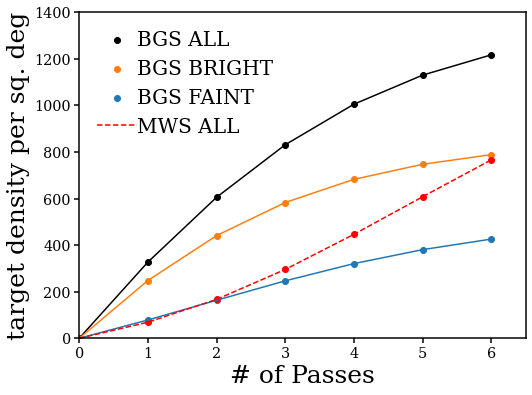

In [15]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

n_bgs_any, n_bgs_bright, n_bgs_faint, n_mws_any = [], [], [], []
for i in range(1,7): 
    obsed = np.any((fa_ngc['NUMOBS_DONE'].data[:,:i]).astype(bool), axis=1)
    
    n_bgs_any.append(np.sum(obsed & is_bgs_any)/f_masked)
    n_bgs_bright.append(np.sum(obsed & is_bgs_bright)/f_masked)
    n_bgs_faint.append(np.sum(obsed & is_bgs_faint)/f_masked)

    n_mws_any.append(np.sum(obsed & is_mws_any)/f_masked)

    
sub.scatter(range(7), [0]+n_bgs_any, c='k', label='BGS ALL')
sub.plot(range(7), [0]+n_bgs_any, c='k')
sub.scatter(range(7), [0]+n_bgs_bright, c='C1', label='BGS BRIGHT')
sub.plot(range(7), [0]+n_bgs_bright, c='C1')
sub.scatter(range(7), [0]+n_bgs_faint, c='C0', label='BGS FAINT')
sub.plot(range(7), [0]+n_bgs_faint, c='C0')

sub.scatter(range(7), [0]+n_mws_any, c='r')
sub.plot(range(7), [0]+n_mws_any, c='r', ls='--', label='MWS ALL')

sub.legend(loc='upper left', fontsize=20, handletextpad=0)
sub.set_xlabel('# of Passes', fontsize=25)
sub.set_xlim(0, 6.5)
sub.set_ylabel('target density per sq. deg', fontsize=25)
sub.set_ylim(0., 1400.)

In [16]:
print('BGS ANY COMPLETENESS') 
print(np.array(n_bgs_any))
print('BGS BRIGHT COMPLETENESS') 
print(np.array(n_bgs_bright))
print('BGS FAINT COMPLETENESS') 
print(np.array(n_bgs_faint))
print()
print('MWS COMPLETENESS') 
print(np.array(n_mws_any))

BGS ANY COMPLETENESS
[ 327.12410432  605.12252266  830.7544768  1004.76814228 1129.58004113
 1216.70064944]
BGS BRIGHT COMPLETENESS
[248.06745054 440.90973936 582.81076829 682.31485567 746.8670485
 788.29921664]
BGS FAINT COMPLETENESS
[ 78.6777308  163.35073353 246.57741489 320.61669432 380.48662281
 425.88475272]

MWS COMPLETENESS
[ 68.99733429 166.9606656  295.46124145 446.22235787 607.49710662
 765.88868574]


In [9]:
print('BGS ANY COMPLETENESS') 
print(np.array(n_bgs_any) / (np.sum(is_bgs_any)/f_masked))
print('BGS BRIGHT COMPLETENESS') 
print(np.array(n_bgs_bright) / (np.sum(is_bgs_bright)/f_masked))
print('BGS FAINT COMPLETENESS') 
print(np.array(n_bgs_faint) / (np.sum(is_bgs_faint)/f_masked))
print()
print('MWS COMPLETENESS') 
print(np.array(n_mws_any) / (np.sum(is_mws_any)/f_masked))

BGS ANY COMPLETENESS
[0.23366007 0.43223037 0.59339605 0.71769153 0.80684289 0.86907189]
BGS BRIGHT COMPLETENESS
[0.28696309 0.510042   0.67419235 0.78929814 0.86397177 0.91190028]
BGS FAINT COMPLETENESS
[0.1477938  0.30684953 0.4631884  0.602269   0.71473289 0.80001194]

MWS COMPLETENESS
[0.03980339 0.09631678 0.17044659 0.25741813 0.3504548  0.44182823]


## how many fibers are used for repeat observations

Lets see the target density of repeat observations

(0.0, 400.0)

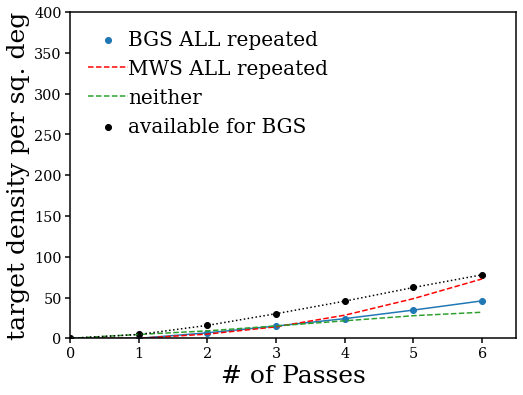

In [18]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

n_bgs_any, n_mws_any, n_neither = [], [], []
for i in range(6): 
    obsed = (np.sum((fa_ngc['NUMOBS_DONE'].data[:,:i]), axis=1) > 0) & (fa_ngc['NUMOBS_DONE'].data[:,i]).astype(bool)
    
    n_bgs_any.append(np.sum(obsed & is_bgs_any)/f_masked)

    n_mws_any.append(np.sum(obsed & is_mws_any)/f_masked)
    
    obsed = (fa_ngc['NUMOBS_DONE'].data[:,i].astype(bool))

    n_neither.append(np.sum(obsed & ~is_mws_any & ~is_bgs_any)/f_masked)

sub.scatter(range(7), [0]+n_bgs_any, c='C0', label='BGS ALL repeated')
sub.plot(range(7), [0]+n_bgs_any, c='C0')

sub.plot(range(7), [0]+n_mws_any, c='r', ls='--', label='MWS ALL repeated')

sub.plot(range(7), [0]+n_neither, c='C2', ls='--', label='neither')

sub.scatter(range(7), [0]+list(np.array(n_bgs_any) + np.array(n_neither)), c='k', label='available for BGS')
sub.plot(range(7), [0]+list(np.array(n_bgs_any) + np.array(n_neither)), c='k', ls=':')

sub.legend(loc='upper left', fontsize=20, handletextpad=0)
sub.set_xlabel('# of Passes', fontsize=25)
sub.set_xlim(0, 6.5)
sub.set_ylabel('target density per sq. deg', fontsize=25)
sub.set_ylim(0., 400.)
#sub.set_title('repeated targets per pass', fontsize=25)

In [19]:
print(n_bgs_any)
print(n_mws_any)
print(n_neither)

[0.0, 6.717100449830062, 15.020348783936372, 24.113612046592866, 34.606818076091905, 45.92694455291177]
[0.0, 5.125722639097013, 14.102447351838721, 28.352319423044662, 48.649565324036935, 72.83807386460552]
[4.7112756368598445, 9.138161687898853, 15.157116294674637, 21.462532722282447, 27.715551207464557, 31.987414344095328]


In [20]:
np.sum(np.array(n_bgs_any)[-2:] + np.array(n_neither)[-2:])

140.23672818056357

What are these targets that are assigned to neither BGS nor MGS? 

In [13]:
print('\t all \t BGS or MWS')
for i in range(6): 
    print('pass %i: %i \t %i' % (i, np.sum(fa_ngc['NUMOBS_DONE'].data[:,i]), np.sum(fa_ngc['NUMOBS_DONE'].data[:,i][is_bgs_any | is_mws_any])))

	 all 	 BGS or MWS
pass 0: 4061233 	 4013489
pass 1: 4021675 	 3929069
pass 2: 4036548 	 3882946
pass 3: 4039506 	 3822005
pass 4: 4022869 	 3742000
pass 5: 4014832 	 3690672


In [14]:
np.unique(fa_ngc[~is_bgs_any & ~is_mws_any]['TARGET_STATE'][~fa_ngc[~is_bgs_any & ~is_mws_any]['TARGET_STATE'].mask])

BRIGHT_HPM|UNOBS
CALIB
DWF_BRIGHT_HI|UNOBS
DWF_BRIGHT_LO|UNOBS
GC_BRIGHT|UNOBS
MWS_FAINT_BLUE|UNOBS
MWS_FAINT_RED|UNOBS
MWS_MAIN_CLUSTER_SV|UNOBS
MWS_RR_LYRAE|UNOBS
PSF_OUT_BRIGHT|UNOBS
PV_BRIGHT_HIGH|UNOBS
